# MLT analysis of SMS convection

In [1]:
%pylab ipympl
from scipy import interpolate
from scipy import optimize
from nugridpy import astronomy as ast
from nugridpy import mesa as ms
from nugridpy import ascii_table
from nugridpy import utils as ut
sys.path.insert(0,'/home/user/user/niagara_scratch_sblouin/PyPPM')
from ppmpy import ppm  
from ppmpy import ppmsetup as ps
import os
logging.getLogger("matplotlib").setLevel(logging.ERROR)

Populating the interactive namespace from numpy and matplotlib


### Load 1D model 

In [2]:
boost = 1000 # boost factor for Krad and Lum (since I am comparing to V3 here)

In [3]:
_,mass,rho,T,entropy,mu,kappa,eps,radius,pressure = genfromtxt('../setup/tyrone/0.1Msun__yr_1e4Msun_more.dat', unpack=True, skip_header=1)
mass = mass*1.988435e33
kappa = kappa/boost
eps = eps*boost

### Compute all required quantities for MLT

Equation 7.12 of Kippenhahn: $U \equiv \frac{3 acT^3}{c_P \rho^2 \kappa \ell_{\rm MLT}^2} \sqrt{\frac{8 H_P}{g \delta}}$

Equation 7.13 of Kippenhahn: $W \equiv \nabla_{\rm rad} - \nabla_{\rm ad}$

Equation 7.26 of Kippenhahn: $\left( \sqrt{x+U^2} - U \right)^3 + \frac{8}{9} U (x-W) = 0$, where $x \equiv \nabla - \nabla_{\rm ad}$ is the over-adiabadicity.

$P = \frac{R \rho T}{\mu} + \frac{a T^4}{3}$

$\delta \equiv - \left( \frac{\partial \ln \rho}{\partial \ln T} \right)_P = \frac{\mu}{\rho R} \left( \frac{P}{T} + a T^3 \right) = \frac{4}{\beta}-3$

$\beta \equiv P_{\rm gas}/P$, with $P = P_{\rm gas} + P_{\rm rad}$

$\nabla_{\rm ad} = \frac{8-6\beta}{32-24\beta-3\beta^2}$

$c_P = \frac{R}{\mu} \frac{1}{2 \beta^2} \left(32 - 24 \beta - 3 \beta^2 \right)$

$\nabla_{\rm rad} = \frac{3}{16 \pi a c G} \frac{\kappa L P}{mT^4}$

$\Gamma_1 = \frac{32-24\beta-3\beta^2}{24-21\beta}$

In [4]:
R = 8.31446261815324e7
a = 7.5646e-15
c = 2.99792458e10
G = 6.67430e-8

In [5]:
Pgas = R*rho*T/mu
Prad = a*T**4/3
P = Pgas + Prad
beta = Pgas/P

In [6]:
def cdiff(x):
    # compute 2nd order centred differences
    dx = (np.roll(x, -1) - np.roll(x, 1))/2.

    # 1st order differences to correct the boundaries
    dx[0] = x[1] - x[0]
    dx[-1] = x[-1] - x[-2]

    return dx

In [7]:
Hp = np.abs(cdiff(radius))/(np.abs(cdiff(np.log(P))) + 1e-100)

In [8]:
nabla_ad = (8-6*beta)/(32-24*beta-3*beta**2)
cp = ((R/mu)/(2*beta**2))*(32-24*beta-3*beta**2)
delta = 4/beta - 3

In [9]:
L = [trapz(y=eps[:i]*rho[:i]*4*pi*radius[:i]**2, x=radius[:i]) for i in range(len(radius))]

In [10]:
nabla_rad = (3/(16*pi*a*c*G))*((kappa*L*P)/(mass*T**4+1e-100))

In [11]:
g = G*mass/radius**2

In [12]:
Q = (4-3*beta)/beta
G1 = (32-24*beta-3*beta**2)/(24-21*beta)
cs = sqrt(G1*pressure/rho)

### Get PPMstar superadiabadicity

In [13]:
from scipy.optimize import root
from scipy.signal import savgol_filter

In [14]:
nominal_heat = 0.1485 # Nominal luminosity in code units
eos = 'r' # EOS used for the run
dir = '/home/user/user/'
runs = ['V3']
ddir = ['niagara_scratch_fherwig/V3-1000xL-1000xK-1152-TyroneM1e4_0.1']
rprof = {}
for i,run in enumerate(runs):
    rprof_dir = os.path.join('/home/user/user',ddir[i],'prfs')
    rprof[run] = ppm.RprofSet(rprof_dir)    

1127 rprof files found in '/home/user/user/niagara_scratch_fherwig/V3-1000xL-1000xK-1152-TyroneM1e4_0.1/prfs/.
Dump numbers range from 0 to 1126.


In [23]:
run = 'V3'
dumps = arange(926,1126,5)
avg1 = rprof[run].average_profiles(fname=dumps,var='nabla_T')
avg2 = rprof[run].average_profiles(fname=dumps,var='nabla_T_ad')
# ppm_r,ppm_x = avg1['R'],savgol_filter(avg1['nabla_T']-avg2['nabla_T_ad'],31,1)
ppm_r,ppm_x = avg1['R'],avg1['nabla_T']-avg2['nabla_T_ad']

### Solve MLT for superadiabadicity

$\left( \sqrt{x+U^2} - U \right)^3 + \frac{8}{9} U (x-W) = 0$, where $x \equiv \nabla - \nabla_{\rm ad}$ is the over-adiabadicity.

In [16]:
matplotlib.rcParams.update({'font.size': 12})
import matplotlib.ticker as mticker

In [17]:
Rmax = 1e8*15000

In [18]:
def func(xi,Ui,Wi):
    ans = (sqrt(xi+Ui**2)-Ui)**3 + (8/9)*Ui*(xi-Wi)
    return ans

In [19]:
rmin,rmax = 2000,8000

In [20]:
ut.linestylecb(7)[2]

(0.8117647058823529, 0.8117647058823529, 0.8117647058823529)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


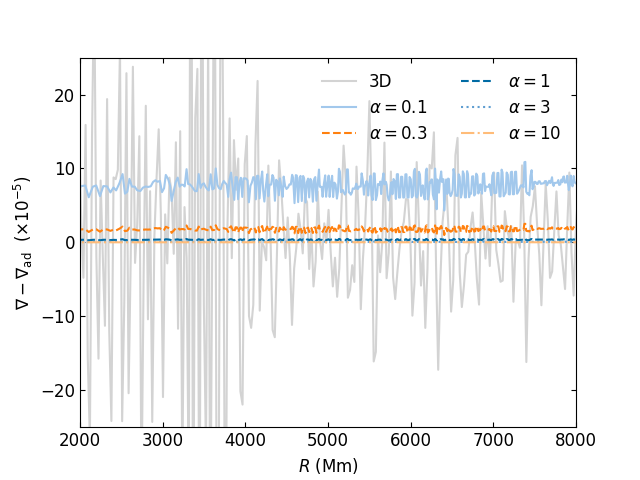

In [21]:
close(4);figure(4)
plot(ppm_r, 1e5*ppm_x, color='lightgrey', label='3D')
# plot(ppm_r, ones(len(ppm_r))*mean(1e5*ppm_x[(ppm_r>rmin)&(ppm_r<rmax)]), 
     # color='grey', label='3D (radially averaged)')
for j,alpha_MLT in enumerate([0.1,0.3,1,3,10]):
    ell_MLT = alpha_MLT*Hp
    U = ((3*a*c*T**3)/(cp*rho**2*kappa*ell_MLT**2))*sqrt(8*Hp/(g+1e-100)/delta)
    W = nabla_rad - nabla_ad
    x = []
    for i,_ in enumerate(radius[radius<Rmax]):
        sol = root(func, x0=0, args=(U[i],W[i]))
        x.append(sol.x[0])
    if j==2:
        j=5
    if j==4:
        j=6
    x = array(x)
    plot(radius[radius<Rmax]/1e8,1e5*x,ut.linestyle(j)[0],
             label=r'$\alpha='+str(alpha_MLT)+'$',
             color=ut.linestylecb(j)[2], marker=None)
ylim(-25.,25)
xlim(rmin,rmax)
legend(frameon=False,loc=1,ncol=2)
xlabel('$R$ (Mm)')
ylabel(r'$\nabla- \nabla_{\rm ad}$  ($\times 10^{-5}$)')
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

## Diffusion coefficient and MLT

In [25]:
avg = rprof[run].average_profiles(fname=dumps,var=['|Ur|','Mach','Hp','|U|'])
ppm_r,ppm_Urrms,ppm_Ma,ppm_Hp,ppm_Urms = avg['R'],avg['|Ur|'],avg['Mach'],avg['Hp'],avg['|U|']

In [35]:
def diffusion_analysis(rp,delta_range,fraction,runid,min_max_range,rlim,Dlims,fit_rlim=True,\
                       varlim=(1.e-5,1.5),var='Xcld',sparse=1,ifig0=1):
    dumpc = np.diff(np.array(min_max_range))[0]//2 + min_max_range[0]
    range1 = list(range(min_max_range[0],dumpc - delta_range//2,sparse))
    range2 = list(range(dumpc + delta_range//2,min_max_range[1],sparse))
    print("central dump, and range1 and 2: ",dumpc,range1,range2)
    Hp = rp.compute_Hp(fname=dumpc)
    Rr = rp.get('R',fname=dumpc)
    cb = rp.bound_rad(dumpc,7000,12000,var='ut',criterion='min_grad')
    hpbnds = Hp[np.where(Rr>cb)][-1]
    print('Convective boundary: {:.3f}Mm'.format(cb[0]))
    print('Pressure scale height at convective boundary: {:.3f}Mm'.format(hpbnds))
    
    if not fit_rlim == None:
        fit_rlim=[cb,cb+fraction*hpbnds]; print(fit_rlim)
            
    res=rp.DsolveLgr(range1,range2,integrate_upwards=True,rlim=rlim,fit_rlim=fit_rlim,\
                  run_id=runid,logvar=True,Dlim=Dlims,varlim=varlim,var=var,ifig0=ifig0,show_plots=False)
    return cb,res

In [36]:
min_dump, end_dump = min(dumps),max(dumps)
delta_dump = end_dump - min_dump
min_max_range = [min_dump, min_dump+delta_dump]   # this is considered the useable range
delta_range   = 0  # number of dumps between upper limit of low range 
sparse=5
fraction = 0.2
case = run
r_min_plot, r_max_plot = 5000, 12000
Dlims = (1.e8,1.e15)
sb,cb,res = diffusion_analysis(rprof[run],delta_range,fraction,case,\
                 min_max_range,(r_min_plot,r_max_plot),Dlims,fit_rlim=None,
                           varlim=(1e-3,1.),var='FV', sparse=sparse,ifig0=20+i)
D_D = res['D']
radius_D = rprof[run].get('R',int(0.5*min_dump+0.5*end_dump))

central dump, and range1 and 2:  1023 [926, 931, 936, 941, 946, 951, 956, 961, 966, 971, 976, 981, 986, 991, 996, 1001, 1006, 1011, 1016, 1021] [1023, 1028, 1033, 1038, 1043, 1048, 1053, 1058, 1063, 1068, 1073, 1078, 1083, 1088, 1093, 1098, 1103, 1108, 1113, 1118]
Convective boundary: 8770.649Mm
Pressure scale height at convective boundary: 2402.147Mm
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.
Dump 0 at t = 0.00 min is the closest to t = 0.00 min.


ValueError: not enough values to unpack (expected 3, got 2)

In [81]:
def alpha_model(dr,a,b,c):
    # return minimum(alpha_MLT*ones(len(dr)), a+b*dr)
    return minimum(alpha_MLT*ones(len(dr)), a*dr**2+b*dr+c)
    # return minimum(alpha_MLT*ones(len(dr)), a*exp(b*(dr+c)))

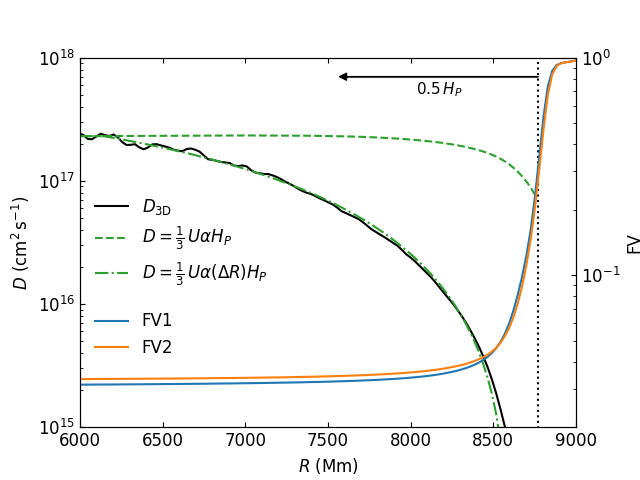

In [91]:
close(67);figure(67)
semilogy(radius_D,D_D,  color='black', label=r'$D_{\rm 3D}$')
ylabel(r'$D$ (cm$^2\,$s$^{-1}$)')
xlabel('$R$ (Mm)')
ylim(1e15,1e18)
xlim(6000,9000)
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.xaxis.set_ticks_position('both')

alpha_MLT = 0.48

# # MLT with v_MLT
# a0 = 9/4
# ell_MLT = alpha_MLT*Hp
# A = (sqrt(Q)*cp*kappa*g*(rho**2.5)*ell_MLT**2)/(12*sqrt(2)*a*c*sqrt(pressure)*T**3)
# Ma_MLT = (sqrt(Q)*alpha_MLT/2/sqrt(2)/sqrt(G1))*((nabla_rad-nabla_ad)/a0/A)**(1/3)
# v_MLT = cs*Ma_MLT
# D_MLT = (1./3.)*v_MLT*ell_MLT
# radius = array(radius)
# semilogy(radius[radius/1e8<cb]/1e8, savgol_filter(D_MLT[radius/1e8<cb],33,1),
#          ut.linestyle(j)[0],label=r'$D=\frac{1}{3} v_{\rm MLT} \ell_{\rm MLT}$',color=ut.linestylecb(j)[2], marker=None)

# MLT with v_PPM
ell_MLT = 1e8*alpha_MLT*ppm_Hp
v_PPM = 1e8*ppm_Urms
D_MLT = (1./3.)*v_PPM*ell_MLT
semilogy(ppm_r[ppm_r<cb], D_MLT[ppm_r<cb], 
         ut.linestyle(1)[0],label=r'$D=\frac{1}{3}\, U \alpha H_P$',color='tab:green', marker=None)

# MLT with v_PPM and special cut-off
sb = 8400 # in the initial setup
dr = (sb-ppm_r)/ppm_Hp
ell_MLT = 1e8*ppm_Hp*alpha_model(dr,0.52507437, 0.19300133, 0.01201772)
D_MLT = (1./3.)*v_PPM*ell_MLT
semilogy(ppm_r[ppm_r<cb], D_MLT[ppm_r<cb], 
         ut.linestyle(2)[0],label=r'$D=\frac{1}{3}\, U \alpha(\Delta R) H_P$',color='tab:green', marker=None)
legend(frameon=False,loc=6)

# Hp reference
annotate(xy=(cb-0.5*interp(cb,ppm_r[::-1],ppm_Hp[::-1]),7e17),text='',
         xytext=(cb,7e17),arrowprops=dict(facecolor='k', 
                            edgecolor='k', width=0.1, headwidth=5, headlength=5),)
text(cb-0.25*interp(cb,ppm_r[::-1],ppm_Hp[::-1]),5e17,r'$0.5\,H_P$', ha='center', size=11)

# plot FV for reference
ax2 = ax.twinx()
ax2.semilogy(radius_D,res['x1'],color='C0',label='FV1')
ax2.semilogy(radius_D,res['x2'],color='C1',label='FV2')
ax2.set_ylabel('FV')
ax2.tick_params(axis='both',direction='in',which='both')
legend(frameon=False,bbox_to_anchor=(0.00,0.15))


vlines(cb,1e-3,10,ls=':',color='k')
ylim(0.02,1)

savefig('diffusivity.pdf', bbox_inches='tight')

In [87]:
from scipy.optimize import curve_fit

(0.0, 0.7)

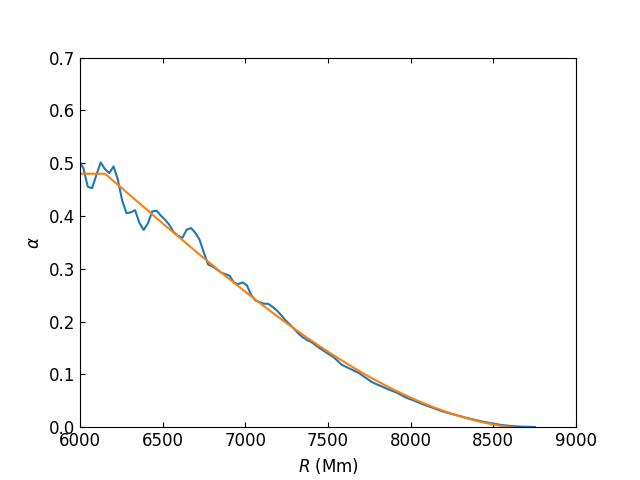

In [96]:
close(688);figure(688)
ylabel(r'$\alpha$')
xlabel('$R$ (Mm)')
xlim(6000,9000)
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.xaxis.set_ticks_position('both')

v_PPM = 1e8*ppm_Urms
D_MLT = (1./3.)*v_PPM*1e8*ppm_Hp
alpha_measured = interp(ppm_r[ppm_r<cb],radius_D[::-1],D_D[::-1])/D_MLT[ppm_r<cb]
r_plot = ppm_r[ppm_r<cb]
plot(r_plot, alpha_measured)

# fit alpha
dr = (sb-ppm_r[ppm_r<cb])/ppm_Hp[ppm_r<cb]
popt,pcov = curve_fit(alpha_model, dr[r_plot>6000], alpha_measured[r_plot>6000], p0=[0.1,0.01,0.1])
plot(r_plot, alpha_model(dr,popt[0],popt[1],popt[2]))

ylim(0,0.7)

In [92]:
popt

array([0.53503525, 0.18855813, 0.01200042])